# Water Classification XGBOOST 

Version: DEMO

ILAB Team

Kernel to use:
- (ADAPT PRISM) `Python [conda env:ilab]`


This is a demo notebook showcasing how the ILAB team uses the XGBoost classifier algorithm. This notebook also demonstates how to use a raster as a test data-set for the trained model.

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, recall_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import train_test_split 
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
GPU = True
DATA_TYPE = np.int16

In [3]:
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

Add names from above to this list to drop them from training and testing.

For example:

```python
columnsToDrop = ['sur_refl_b01_1', 'sur_refl_b07_1', 'ndwi1']
```

In [4]:
columnsToDrop = []

This is a 1000 row training dataset which has columns for all the features listed in v_names. MODIS MOD09GA and MOD09GQ were the data sources.

In [5]:
dfPath = '../data/WaterClassificationPowell.parquet.gzip'

In [6]:
outputRasterPath = '.'

In [7]:
df = pd.read_parquet(dfPath).astype(DATA_TYPE)
df = df.drop(columns=columnsToDrop)
X = df.drop(['water'], axis=1)
y = df['water']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [9]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,800.0,1240.48125,1322.694197,8.0,241.00,924.5,1907.25,9222.0
sur_refl_b02_1,800.0,1613.66375,1585.919064,1.0,172.75,1447.5,2674.25,8837.0
sur_refl_b03_1,800.0,759.86125,1044.525211,-100.0,271.75,567.5,863.50,8909.0
sur_refl_b04_1,800.0,1048.27625,1099.512944,6.0,396.50,838.5,1346.25,9162.0
sur_refl_b05_1,800.0,1992.77625,1488.905919,-92.0,538.50,1857.0,3261.50,6382.0
sur_refl_b06_1,800.0,1949.06250,1555.316968,45.0,499.00,1527.0,3288.75,6610.0
sur_refl_b07_1,800.0,1601.96125,1407.372021,3.0,306.50,1174.0,2762.00,6128.0
ndvi,800.0,64.24625,2565.801953,-9493.0,-1465.50,761.0,1744.25,8587.0
ndwi1,800.0,-2309.12375,3432.082130,-9862.0,-4577.50,-1627.5,-766.75,8823.0
ndwi2,800.0,-890.51250,3836.686056,-9692.0,-2713.50,-743.0,812.25,9858.0


## XGBOOST

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [15]:
hyperparameters = {'objective': 'binary:logistic',
                   'n_estimators':100,
                   'base_score': None,
                   'booster': None,
                   'colsample_bylevel': None,
                   'colsample_bynode': None,
                   'colsample_bytree': None,
                   'gamma': None,
                   'gpu_id': None,
                   'interaction_constraints': None,
                   'learning_rate': 0.003,
                   'max_delta_step': None,
                   'max_depth': None,
                   'min_child_weight': None,
                   'monotone_constraints': None,
                   'n_jobs': -1,
                   'num_parallel_tree': None,
                   'random_state': None,
                   'reg_alpha': None,
                   'reg_lambda': None,
                   'scale_pos_weight': None,
                   'subsample': None,
                   #'tree_method': '',
                   'validate_parameters': None,
                   'verbosity': None}

In [16]:
classifier = xgb.XGBClassifier(**hyperparameters)

In [17]:
eval_set = [(X_train, y_train), (X_val, y_val)]
eval_metric = ["error","auc"]

In [18]:
classifier.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=10)

[0]	validation_0-error:0.01250	validation_0-auc:0.99664	validation_1-error:0.00000	validation_1-auc:1.00000
[1]	validation_0-error:0.01250	validation_0-auc:0.99664	validation_1-error:0.00000	validation_1-auc:1.00000
[2]	validation_0-error:0.01528	validation_0-auc:0.99661	validation_1-error:0.00000	validation_1-auc:1.00000
[3]	validation_0-error:0.01528	validation_0-auc:0.99661	validation_1-error:0.00000	validation_1-auc:1.00000
[4]	validation_0-error:0.01528	validation_0-auc:0.99660	validation_1-error:0.00000	validation_1-auc:1.00000
[5]	validation_0-error:0.01528	validation_0-auc:0.99660	validation_1-error:0.00000	validation_1-auc:1.00000
[6]	validation_0-error:0.01528	validation_0-auc:0.99660	validation_1-error:0.00000	validation_1-auc:1.00000
[7]	validation_0-error:0.01528	validation_0-auc:0.99660	validation_1-error:0.00000	validation_1-auc:1.00000
[8]	validation_0-error:0.01528	validation_0-auc:0.99661	validation_1-error:0.00000	validation_1-auc:1.00000
[9]	validation_0-error:0.015

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.003, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

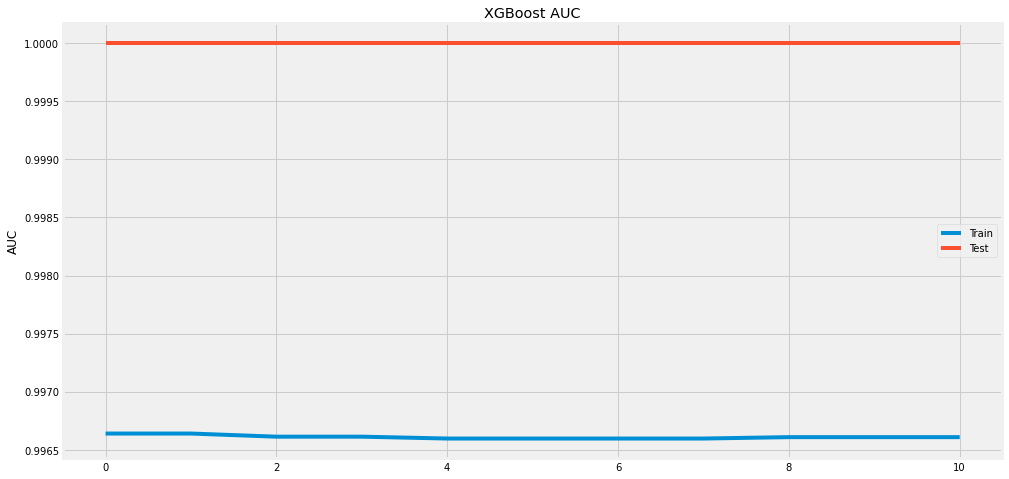

In [19]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

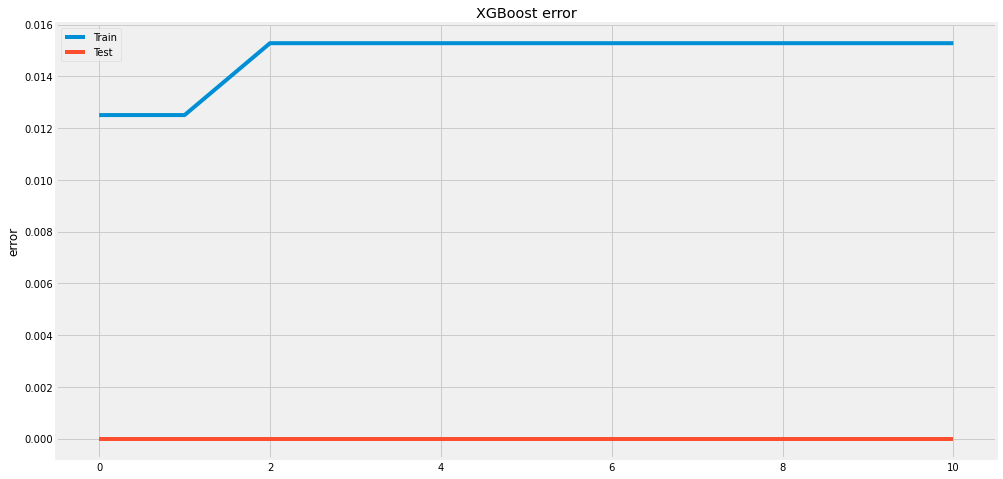

In [20]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('error')
plt.title('XGBoost error')
plt.show()

## Model testing and training/testing data validation

### Get model metrics

In [21]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.975

In [22]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [23]:
test_predictions = test_predictions.astype(np.int32)
y_test_int = y_test.astype(np.int32)

In [24]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       100
           1       0.98      0.97      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

Test Recall
-------------------------------------------------------
0.98
Confusion Matrix
-------------------------------------------------------
[[98  2]
 [ 3 97]]


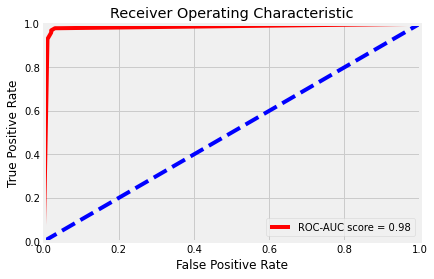

In [25]:
probs = classifier.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC-AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Permutation importance

In [26]:
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

Text(0.5, 0, 'Permutation Importance')

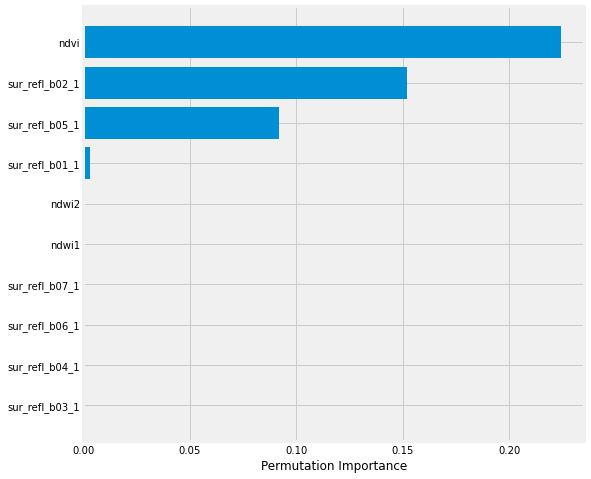

In [27]:
sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [28]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, y_test_int

## Save the model for future use

In [29]:
model_save_path = './water_classifier_xgb.sav'
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: ./water_classifier_xgb.sav
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.003, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


['./water_classifier_xgb.sav']

# Testing: Raster testing

### Read in data 

These are modified MOD09GA and MOD09GQ products for the 2001 julian day 155. They were modified to be clipped to the Lake Powell region.

In [30]:
fileList = sorted([file for file in glob.glob('../data/IL.*.Powell.*.tif') if 'sur_refl' in file])

In [31]:
def readRastersToArray(fileList):
    rasterProjection = None
    newshp = (1300*1300, 10)
    img = np.empty(newshp, dtype=np.int16)
    for i, fileName in enumerate(fileList):
        ds = gdal.Open(fileName)
        img[:, i] = ds.GetRasterBand(1).ReadAsArray().astype(np.int16).ravel()
        if i == 0:
            rasterProjection = ds.GetProjection()
            transform = ds.GetGeoTransform()
        ds = None
    img[:, len(fileList)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(fileList)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(fileList)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    return img, rasterProjection, transform

In [32]:
%%time
im, rasterProjection, transform = readRastersToArray(fileList)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 1547  2461   857 ...  2280  -518   510]
 [ 1474  2377   857 ...  2344  -691   337]
 [ 1474  2377   846 ...  2344  -472   623]
 ...
 [ 2358  2979  1028 ...  1163 -1727 -1292]
 [ 2425  3069  1117 ...  1172 -1721 -1216]
 [ 2402  3038  1117 ...  1169 -1770 -1266]]
33.8 MB size
CPU times: user 240 ms, sys: 36.3 ms, total: 276 ms
Wall time: 287 ms


In [33]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=columnsToDrop)
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [34]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im)

Making predictions from raster
CPU times: user 2.64 s, sys: 54.3 ms, total: 2.69 s
Wall time: 281 ms


In [35]:
shp = (1300, 1300)
left = list()
right = list()
for i, subarr in enumerate(predictedProbaRaster):
    left.append(subarr[0])
    right.append(subarr[1])
leftArr = np.asarray(left)
rightArr = np.asarray(right)
probaLand = leftArr.reshape(shp)
probaWater = rightArr.reshape(shp)

## Inputreshapet raster: description and histogram

In [36]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,1690000.0,2140.144561,807.227853,-100.0,1530.0,2292.0,2756.0,9424.0
sur_refl_b02_1,1690000.0,3276.677008,741.654344,-28672.0,2793.0,3303.0,3780.0,8909.0
sur_refl_b03_1,1690000.0,954.288317,357.504891,-100.0,741.0,963.0,1148.0,7929.0
sur_refl_b04_1,1690000.0,1547.173863,505.923213,-100.0,1199.0,1577.0,1858.0,8526.0
sur_refl_b05_1,1690000.0,3897.447927,875.726008,-95.0,3277.0,3993.0,4528.0,9440.0
sur_refl_b06_1,1690000.0,4009.725915,1122.289522,83.0,3151.0,4271.0,4863.0,8326.0
sur_refl_b07_1,1690000.0,3465.508279,1221.271953,-28672.0,2504.0,3777.0,4416.0,6657.0
ndvi,1690000.0,2338.848757,1416.787988,-31900.0,1525.0,1854.0,2682.0,32203.0
ndwi1,1690000.0,-907.298652,1020.379711,-32272.0,-1428.0,-1105.0,-627.0,32558.0
ndwi2,1690000.0,-30.655925,1514.628116,-32539.0,-886.0,-506.0,367.0,32702.0


#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [37]:
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(1300, 1300)

In [38]:
qa = [file for file in glob.glob('../data/*.tif') if 'qa' in file][0]
ds = gdal.Open(qa)
qaMask = ds.GetRasterBand(1).ReadAsArray()
output = np.where(qaMask == 0, reshp, -9999)
qaMask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

# Generating stats for predicted and truth

### Count num of occurences for each class with the masked predicted result

In [39]:
countNoData = np.count_nonzero(output == -9999)
countLand = np.count_nonzero(output == 0)
countWater = np.count_nonzero(output == 1)
print('Predicted\n No-data occuraces: {}\n Land occurances: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 No-data occuraces: 61568
 Land occurances: 1617958
 Water occurances: 10474


In [40]:
geoTransform = (-9961223.407, 231.65635, 0.0, 4285642.633667, 0.0, -231.65635)

In [41]:
predictedPath = os.path.join(outputRasterPath, 'PowellPredictedWaterMask.tif')

driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(predictedPath, 1300, 1300, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geoTransform)
outDs.SetProjection(rasterProjection)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(output)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

## View predictions with Folium

In [42]:
import folium
from folium import plugins

sys.path.append('../scripts')
import folium_helper

In [43]:
mask_3857 = folium_helper.reproject_to_3857(predictedPath)
mask_d = folium_helper.get_bounds(mask_3857)
mask_b1 = folium_helper.open_and_get_band(mask_3857, 1)
folium_helper.cleanup(mask_3857)
mask_b1 = np.where(mask_b1 == -9999, 0, mask_b1)
zeros = np.zeros_like(mask_b1)
mask_rgb = np.dstack((mask_b1, zeros, zeros))

Transform: | 491.82, 0.00,-12749861.52|
| 0.00,-491.82, 4656230.30|
| 0.00, 0.00, 1.00|
Width: 1670 Height: 770


In [44]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google')

In [45]:
from folium import plugins

In [46]:
m.add_child(folium_helper.get_overlay(mask_rgb, mask_d, 'Water classification XGBOOST predicted mask', opacity=0.6))
m.add_child(plugins.MousePosition())
m.add_child(folium.LayerControl())